# 2022-09-01 Figure 1

This notebook will be analyzing the production results for the 2-qubit case.

In [1]:
from ast import literal_eval
import glob
from IPython.core.display import display, HTML
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
from math import sqrt

import pygsti
from pygsti.baseobjs import Label as L
from pygsti.modelmembers.operations import LindbladErrorgen
from pygsti.tools import optools
from pygsti.protocols import CombinedExperimentDesign
from pygsti.protocols.gst import GateSetTomographyDesign

from pygsti.modelpacks import smq2Q_XYCPHASE

import scipy as sp
from scipy.optimize import curve_fit
#from sklearn.metrics import r2_score
import time

display(HTML('<style>.container { width:90% !important; }</style>'))

np.set_printoptions(precision = 6, linewidth = 200)

/tmp/ipykernel_2370552/816519590.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['lines.markersize'] = 8

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.handlelength'] = 2

### Data loading ###

In [7]:
data_dir_0  = '../data/data_XYCPHASE_L64/'
data_dir_1  = '../data/data_XYCPHASE_L64_Full_Lite/'                      
data_dir_2  = '../data/data_XYCPHASE_L64_Per_Germ_E033C30N1000_Lite/'     
data_dir_3  = '../data/data_XYCPHASE_L64_Per_Germ_E033C30N20000_Lite/'    
data_dir_4  = '../data/data_XYCPHASE_L64_Per_Germ_E25C4N1000_Lite/'       
data_dir_5  = '../data/data_XYCPHASE_L64_Per_Germ_E25C4N20000_Lite/'
data_dir_6  = '../data/data_XYCPHASE_L64_Per_Germ_E5C2N1000_Lite/'  
data_dir_7  = '../data/data_XYCPHASE_L64_Per_Germ_E5C2N20000_Lite/' 
data_dir_8  = '../data/data_XYCPHASE_L64_Per_Germ_Rand_03_Lite/'    
data_dir_9  = '../data/data_XYCPHASE_L64_Per_Germ_Rand_06_Lite/'
data_dir_10 = '../data/data_XYCPHASE_L64_Per_Germ_Rand_09_Lite/'
data_dir_11 = '../data/data_XYCPHASE_L64_Per_Germ_Rand_12_Lite/'
data_dir_12 = '../data/data_XYCPHASE_L64_Per_Germ_Rand_25_Lite/'
data_dir_13 = '../data/data_XYCPHASE_L64_Per_Germ_Rand_50_Lite/'
# This has structure [{fpr key}, {gr key}].for_protocol(model_{model name}_datagen_{datagen index})
#combined_data = pygsti.io.load_results_from_dir(data_dir)

In [8]:
model_pkls = sorted(glob.glob(data_dir_1 + '*.pkl'))

print(model_pkls)

# Keys will be model_name, model_index
noise_models = {}
for mpkl in model_pkls:
    with open(mpkl, 'rb') as f:
        model = pickle.load(f)

    pklname = mpkl.split('/')[-1]
    entries = pklname.split('_')
    model_idx = int(entries[-1].split('.')[0])
    model_name = '_'.join(entries[:-1])
    #print(f'{mpkl}, {pklname}, {entries}, {model_idx}, {model_name}')

    noise_models[(model_name, model_idx)] = model

[]


In [9]:
print(noise_models.keys())

dict_keys([])


In [10]:
target_model = smq2Q_XYCPHASE.target_model('static')

In [11]:
#load in the experiment designs:
edesign_1= GateSetTomographyDesign.from_dir(data_dir_1)
edesign_2= GateSetTomographyDesign.from_dir(data_dir_2)
edesign_3= GateSetTomographyDesign.from_dir(data_dir_3)
edesign_4= GateSetTomographyDesign.from_dir(data_dir_4)
edesign_5= GateSetTomographyDesign.from_dir(data_dir_5)
edesign_6= GateSetTomographyDesign.from_dir(data_dir_6)
edesign_7= GateSetTomographyDesign.from_dir(data_dir_7)
edesign_8= GateSetTomographyDesign.from_dir(data_dir_8)
edesign_9= GateSetTomographyDesign.from_dir(data_dir_9)
edesign_10= GateSetTomographyDesign.from_dir(data_dir_10)
edesign_11= GateSetTomographyDesign.from_dir(data_dir_11)
edesign_12= GateSetTomographyDesign.from_dir(data_dir_12)
edesign_13= GateSetTomographyDesign.from_dir(data_dir_13)

edesign_dict= {('Full', 'Lite'):edesign_1, ('PerGermE0.033C30.00N1000', 'Lite'):edesign_2, ('PerGermE0.033C30.00N20000', 'Lite'):edesign_3,
               ('PerGermE0.250C4.00N1000', 'Lite'):edesign_4, ('PerGermE0.250C4.00N20000', 'Lite'):edesign_5, ('PerGermE0.500C2.00N1000', 'Lite'):edesign_6, 
               ('PerGermE0.500C2.00N20000', 'Lite'):edesign_7, ('PerGermRand0.03-0','Lite'):edesign_8, ('PerGermRand0.06-0','Lite'):edesign_9,
               ('PerGermRand0.09-0','Lite'):edesign_10, ('PerGermRand0.12-0','Lite'):edesign_11, ('PerGermRand0.25-0','Lite'):edesign_12,
               ('PerGermRand0.50-0','Lite'):edesign_13}

comb_edesign=CombinedExperimentDesign(edesign_dict)

In [12]:
print(f'Num Full germs: {len(smq2Q_XYCPHASE.germs(lite=False))}')
print(f'Num Lite germs: {len(smq2Q_XYCPHASE.germs())}')
print(f'Num prep fids: {len(smq2Q_XYCPHASE.prep_fiducials())}')
print(f'Num meas fids: {len(smq2Q_XYCPHASE.meas_fiducials())}')

Num Full germs: 68
Num Lite germs: 15
Num prep fids: 16
Num meas fids: 11


In [13]:
edesign_full = pygsti.protocols.StandardGSTDesign(target_model,
    smq2Q_XYCPHASE.prep_fiducials(), smq2Q_XYCPHASE.meas_fiducials(),
    smq2Q_XYCPHASE.germs(lite=False), [1,2,4,8,16,32,64])

In [14]:
edesign_dict['Full', 'Full'] = edesign_full
comb_edesign = CombinedExperimentDesign(edesign_dict)

In [15]:
comb_edesign.keys()

dict_keys([('Full', 'Lite'), ('PerGermE0.033C30.00N1000', 'Lite'), ('PerGermE0.033C30.00N20000', 'Lite'), ('PerGermE0.250C4.00N1000', 'Lite'), ('PerGermE0.250C4.00N20000', 'Lite'), ('PerGermE0.500C2.00N1000', 'Lite'), ('PerGermE0.500C2.00N20000', 'Lite'), ('PerGermRand0.03-0', 'Lite'), ('PerGermRand0.06-0', 'Lite'), ('PerGermRand0.09-0', 'Lite'), ('PerGermRand0.12-0', 'Lite'), ('PerGermRand0.25-0', 'Lite'), ('PerGermRand0.50-0', 'Lite'), ('Full', 'Full')])

Curious about the number of circuits in each of the designs.

In [16]:
print('Num Ckts Full-Full: ', len(comb_edesign['Full', 'Full'].all_circuits_needing_data))
print('Num Ckts Full-Lite: ', len(comb_edesign['Full', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE.033C30N1000-Lite: ', len(comb_edesign['PerGermE0.033C30.00N1000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE.033C30N20000-Lite: ', len(comb_edesign['PerGermE0.033C30.00N20000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE0.250C4.00N1000-Lite: ', len(comb_edesign['PerGermE0.250C4.00N1000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE0.250C4.00N20000-Lite: ', len(comb_edesign['PerGermE0.250C4.00N20000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE0.500C2.00N1000-Lite: ', len(comb_edesign['PerGermE0.500C2.00N1000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE0.500C2.00N20000-Lite: ', len(comb_edesign['PerGermE0.500C2.00N20000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 50%-Lite: ', len(comb_edesign['PerGermRand0.50-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 25%-Lite: ', len(comb_edesign['PerGermRand0.25-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 12.5%-Lite: ', len(comb_edesign['PerGermRand0.12-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 9%-Lite: ', len(comb_edesign['PerGermRand0.09-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 6%-Lite: ', len(comb_edesign['PerGermRand0.06-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 3%-Lite: ', len(comb_edesign['PerGermRand0.03-0', 'Lite'].all_circuits_needing_data))

Num Ckts Full-Full:  56254
Num Ckts Full-Lite:  13606
Num Ckts PerGermE.033C30N1000-Lite:  6339
Num Ckts PerGermE.033C30N20000-Lite:  6233
Num Ckts PerGermE0.250C4.00N1000-Lite:  6387
Num Ckts PerGermE0.250C4.00N20000-Lite:  6250
Num Ckts PerGermE0.500C2.00N1000-Lite:  6950
Num Ckts PerGermE0.500C2.00N20000-Lite:  6632
Num Ckts PerGermPowerRandom 50%-Lite:  7239
Num Ckts PerGermPowerRandom 25%-Lite:  4013
Num Ckts PerGermPowerRandom 12.5%-Lite:  2363
Num Ckts PerGermPowerRandom 9%-Lite:  1856
Num Ckts PerGermPowerRandom 6%-Lite:  1546
Num Ckts PerGermPowerRandom 3%-Lite:  1105


In [17]:
#Load in the Pandas dataframes.
analysis_df_1 = pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_full_lite.partial.h5')
analysis_df_2 = pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermE033C30N1000_lite.partial.h5')
analysis_df_3 = pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermE033C30N20000_lite.partial.h5')
analysis_df_4 = pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermE25C4N1000_lite.partial.h5')
analysis_df_5 = pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermE25C4N20000_lite.partial.h5')
analysis_df_6 = pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermE5C2N1000_lite.partial.h5')
analysis_df_7 = pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermE5C2N20000_lite.partial.h5')
analysis_df_8 = pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermrand03_lite.partial.h5')
analysis_df_9 = pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermrand06_lite.partial.h5')
analysis_df_10= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermrand09_lite.partial.h5')
analysis_df_11= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermrand12_lite.partial.h5')
analysis_df_12= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermrand25_lite.partial.h5')
analysis_df_13= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_0_pergermrand50_lite.partial.h5')
analysis_df_14= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_full_lite.partial.h5')
analysis_df_15= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermE033C30N1000_lite.partial.h5')
analysis_df_16= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermE033C30N20000_lite.partial.h5')
analysis_df_17= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermE25C4N1000_lite.partial.h5')
analysis_df_18= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermE25C4N20000_lite.partial.h5')
analysis_df_19= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermE5C2N1000_lite.partial.h5')
analysis_df_20= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermE5C2N20000_lite.partial.h5')
analysis_df_21= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermrand03_lite.partial.h5')
analysis_df_22= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermrand06_lite.partial.h5')
analysis_df_23= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermrand09_lite.partial.h5')
analysis_df_24= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermrand12_lite.partial.h5')
analysis_df_25= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermrand25_lite.partial.h5')
analysis_df_26= pd.read_hdf('../data/dataframes/H_XYCPHASE_1e-2_normal_depol_0_pergermrand50_lite.partial.h5')

In [18]:
#analysis_df_1

In [19]:
#combine the dataframes into a single data frame object:
df_list= [analysis_df_1,analysis_df_2, analysis_df_3, analysis_df_4, analysis_df_5, analysis_df_6, analysis_df_7,
          analysis_df_8, analysis_df_9, analysis_df_10,analysis_df_11,analysis_df_12,analysis_df_13,analysis_df_14,
          analysis_df_15,analysis_df_16,analysis_df_17,analysis_df_18,analysis_df_19,analysis_df_20,analysis_df_21,
          analysis_df_22,analysis_df_23,analysis_df_24,analysis_df_25,analysis_df_26]
combined_frame= pd.concat(df_list)

In [20]:
combined_frame['FPR'].unique()

array(['Full', 'PerGermE033C30N1000', 'PerGermE033C30N20000', 'PerGermE25C4N1000', 'PerGermE25C4N20000', 'PerGermE5C2N1000', 'PerGermE5C2N20000', 'PerGermRand0.03', 'PerGermRand0.06',
       'PerGermRand0.09', 'PerGermRand0.12', 'PerGermRand0.25', 'PerGermRand0.50'], dtype=object)

In [21]:
combined_frame[combined_frame['FPR']=='PerGermRand0.12']['GR'].unique()

array(['Lite'], dtype=object)

In [22]:
combined_frame.head()

,FPR,FPR Index,GR,Model,Model Index,Datagen Index,Parameterization,Num GST Iterations,Gate,L,JTD,Eval MAE,Angle MAE,Diamond Dist
0,Full,0,Lite,H_XYCPHASE_1e-2_normal_depol,0,2021,full TP,7,Gxpi2:1,"[1, 2, 4, 8, 16, 32, 64]","[0.12734552366382346, 0.04912550663674367, 0.0...","[0.02250215857183911, 0.008508343461610517, 0....","[0.014798341734184456, 0.005889595677169242, 0...","[0.3080422299590553, 0.12353207953135903, 0.04..."
1,Full,0,Lite,H_XYCPHASE_1e-2_normal_depol,0,2021,full TP,7,Gypi2:1,"[1, 2, 4, 8, 16, 32, 64]","[0.12366046685463247, 0.03836503253396869, 0.0...","[0.028308736130225196, 0.007007453746821511, 0...","[0.008139094468201742, 0.003274174632690293, 0...","[0.2931841413074208, 0.08510045047353962, 0.05..."
2,Full,0,Lite,H_XYCPHASE_1e-2_normal_depol,0,2021,full TP,7,Gxpi2:0,"[1, 2, 4, 8, 16, 32, 64]","[0.10958556648629017, 0.04347846664940971, 0.0...","[0.019393059750634357, 0.006934665713255501, 0...","[0.008128596816068392, 0.004797102209196035, 0...","[0.3204544540271995, 0.1236737561857687, 0.037..."
3,Full,0,Lite,H_XYCPHASE_1e-2_normal_depol,0,2021,full TP,7,Gypi2:0,"[1, 2, 4, 8, 16, 32, 64]","[0.10978659284812117, 0.0412022218210503, 0.02...","[0.020005845730742135, 0.005918612441200351, 0...","[0.016395443226843033, 0.002726910133930222, 0...","[0.30129998101498073, 0.0878314844357436, 0.05..."
4,Full,0,Lite,H_XYCPHASE_1e-2_normal_depol,0,2021,full TP,7,Gcphase:0:1,"[1, 2, 4, 8, 16, 32, 64]","[0.13974062602222326, 0.04479764679912117, 0.0...","[0.054151884664509854, 0.02337378277066372, 0....","[1.2006481822423176, 0.020319447026307384, 1.9...","[0.31282608604372575, 0.09941544127885234, 0.0..."


In [23]:
#analysis_df.loc[analysis_df['FPR']=='PerGermRand0.12']

### Calculate Average Diamond Norm Distances ###

In [24]:
#Take as input a dataframe object, FPR type, germ reduction type and parameterization and returned a list of the per iteration diamond distance
#averaged over the gate set for all models and dataset instantiations. This is is flattened with respect the the dataset and noisy model
#instantiations.
#Hardcode in the XYI gateset for now, can update this to pull in the gates from the target model later.
def average_gateset_diamond_distance_periter(dataframe, FPR_type, GR_type, parameterization, split_depol=False):
    """
    if split_depol is true then we separately out the coherent-only and coherent+depolarization model types.
    """    
    #Extract all of the rows from the dataframe object corresponding to the selected FPR_type, GR_type and parameterization.
    extracted_rows= dataframe[(dataframe['FPR']==FPR_type) & (dataframe['GR']==GR_type) & (dataframe['Parameterization']==parameterization)]
    #This returns a dataframe with just the desired rows.
    #Set a list of gate labels.
    gate_labels= ['Gxpi2:1', 'Gypi2:1', 'Gxpi2:0', 'Gypi2:0', 'Gcphase:0:1']
    #Now, for each (FPR Index, Model, Model Index, Datagen index) tuple we need to average the diamond distance over the
    #Get unique fpr indices, only relevant for random FPR where we may have multiple random instantiations.
    unique_fpr_indices = extracted_rows['FPR Index'].unique()
    #unique model labels
    unique_model_labels= extracted_rows['Model'].unique()
    #unique model instantiation indexes
    unique_model_indices= extracted_rows['Model Index'].unique()
    #finally, unique data generation instantiations
    unique_datagen_indices= extracted_rows['Datagen Index'].unique()
    
    
    if split_depol==False:
        #just stick the averages into a single list
        avg_gateset_ddists=[]
    else:
        #otherwise we need a nested list for the two model types.
        avg_gateset_ddists1=[]
        avg_gateset_ddists2=[] 
    
    #Now iterate through all of the combinations of these and average over the gates:
    for fpr, mdl_lbl, mdl_idx, datagen_idx in itertools.product(unique_fpr_indices, unique_model_labels, unique_model_indices, unique_datagen_indices):
        #pull out the rows corresponding to these labels/indices:
        rows_to_average= extracted_rows[(extracted_rows['FPR Index']==fpr) & (extracted_rows['Model']==mdl_lbl) &
                                        (extracted_rows['Model Index']==mdl_idx) & (extracted_rows['Datagen Index']== datagen_idx)]
        #pull out the diamond distances for these rows and turn them into a numpyarray, on second though I shouldn't actually need
        #to index by gate since that should be the only free parameter left. A quick test confirms this.
        if rows_to_average.empty:
            continue
        per_gate_ddists= rows_to_average['Diamond Dist']
        try:
            avg_gate_ddist= np.asarray(per_gate_ddists.iloc[0])
        except IndexError as error:
            print(error, per_gate_ddists, rows_to_average, sep = '\n')
            print(f'fpr = {fpr}, mdl_lbl = {mdl_lbl}, mdl_idx = {mdl_idx}, dg_idx = {datagen_idx}')
        for i in range(1,len(per_gate_ddists)):
            avg_gate_ddist += np.asarray(per_gate_ddists.iloc[i])
        avg_gate_ddist= avg_gate_ddist/len(per_gate_ddists)
        #append this to a running list of average diamond distances
        #different behavior here depending on whether we are separating out the two model types.
        
        if split_depol==False:
            avg_gateset_ddists.append(avg_gate_ddist)
        else:
            if 'depol' in mdl_lbl:
                avg_gateset_ddists2.append(avg_gate_ddist)
            else: 
                avg_gateset_ddists1.append(avg_gate_ddist)
    if split_depol==False:
        return avg_gateset_ddists
    else:
        return (avg_gateset_ddists1, avg_gateset_ddists2)

In [25]:
avg_gateset_ddists_full_lite_TP = average_gateset_diamond_distance_periter(combined_frame, 'Full', 'Lite', 'full TP', split_depol=True)
print(len(avg_gateset_ddists_full_lite_TP[0]), avg_gateset_ddists_full_lite_TP)

1 ([array([0.275668, 0.102341, 0.046374, 0.013831, 0.008123, 0.005356, 0.003323])], [array([0.307161, 0.103911, 0.050051, 0.017975, 0.010444, 0.006816, 0.004675])])


In [26]:
avg_gateset_ddists_full_lite_TP_coher, avg_gateset_ddists_full_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'Full', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE033C30N1000_lite_TP_coher, avg_gateset_ddists_pergermE033C30N1000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermE033C30N1000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE033C30N20000_lite_TP_coher, avg_gateset_ddists_pergermE033C30N20000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermE033C30N20000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE25C4N1000_lite_TP_coher, avg_gateset_ddists_pergermE25C4N1000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermE25C4N1000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE25C4N20000_lite_TP_coher, avg_gateset_ddists_pergermE25C4N20000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermE25C4N20000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE5C2N1000_lite_TP_coher, avg_gateset_ddists_pergermE5C2N1000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermE5C2N1000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE5C2N20000_lite_TP_coher, avg_gateset_ddists_pergermE5C2N20000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermE5C2N20000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand05_lite_TP_coher, avg_gateset_ddists_pergermrand05_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.50', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand025_lite_TP_coher, avg_gateset_ddists_pergermrand025_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.25', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand012_lite_TP_coher, avg_gateset_ddists_pergermrand012_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.12', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand009_lite_TP_coher, avg_gateset_ddists_pergermrand009_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.09', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand006_lite_TP_coher, avg_gateset_ddists_pergermrand006_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.06', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand003_lite_TP_coher, avg_gateset_ddists_pergermrand003_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'PerGermRand0.03', 'Lite', 'full TP', split_depol=True)

In [27]:
def get_shot_counts_by_L(edesign, num_shots=1e4):
    
    ckt_lists= edesign.circuit_lists
    
    #Take the pairwise set differences of each of these circuit lists to get the unique circuits per iteration:
    unique_ckts_by_iter= [ckt_lists[0]]
    
    for i in range(1,len(ckt_lists)):
        unique_ckts_by_iter.append(list(set(ckt_lists[i])-set(ckt_lists[i-1])))
                                   
    #Now put together the dictionary for L vs shots:
    total_shots = 0
    cumul_L_shots = {}
    for i in range(len(ckt_lists)):
        total_shots += len(unique_ckts_by_iter[i])*num_shots
        cumul_L_shots[2**i]= total_shots
                                   
    return cumul_L_shots

In [28]:
fl_shots = get_shot_counts_by_L(comb_edesign['Full','Lite'], num_shots=1)
print(fl_shots)

{1: 731, 2: 1509, 4: 3175, 8: 5779, 16: 8388, 32: 10997, 64: 13606}


# Panel B

In [29]:
lengths= [1, 2, 4, 8, 16, 32, 64]

Load in the information matrices for the two qubit experiment designs.

In [30]:
FIM_full_lite                 = np.load('../data/data_XYCPHASE_L64_Full_Lite/cumul_fim_Full_Lite.npz')
FIM_pergermE033C30N1000_lite  = np.load('../data/data_XYCPHASE_L64_Per_Germ_E033C30N1000_Lite/cumul_fim_PerGermE033C30N1000_Lite.npz')
FIM_pergermE033C30N20000_lite = np.load('../data/data_XYCPHASE_L64_Per_Germ_E033C30N20000_Lite/cumul_fim_PerGermE033C30N20000_Lite.npz')
FIM_pergermE25C4N1000_lite    = np.load('../data/data_XYCPHASE_L64_Per_Germ_E25C4N1000_Lite/cumul_fim_PerGermE25C4N1000_Lite.npz')
FIM_pergermE25C4N20000_lite   = np.load('../data/data_XYCPHASE_L64_Per_Germ_E25C4N20000_Lite/cumul_fim_PerGermE25C4N20000_Lite.npz')
FIM_pergermE5C2N1000_lite     = np.load('../data/data_XYCPHASE_L64_Per_Germ_E5C2N1000_Lite/cumul_fim_PerGermE5C2N1000_Lite.npz')
FIM_pergermE5C2N20000_lite    = np.load('../data/data_XYCPHASE_L64_Per_Germ_E5C2N20000_Lite/cumul_fim_PerGermE5C2N20000_Lite.npz')
FIM_pergermrand05_lite        = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_50_Lite/cumul_fim_PerGermRand0.50_Lite.npz')
FIM_pergermrand025_lite       = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_25_Lite/cumul_fim_PerGermRand0.25_Lite.npz')
FIM_pergermrand012_lite       = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_12_Lite/cumul_fim_PerGermRand0.12_Lite.npz')
FIM_pergermrand009_lite       = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_09_Lite/cumul_fim_PerGermRand0.09_Lite.npz')
FIM_pergermrand006_lite       = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_06_Lite/cumul_fim_PerGermRand0.06_Lite.npz')
FIM_pergermrand003_lite       = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_03_Lite/cumul_fim_PerGermRand0.03_Lite.npz')

In [31]:
fisher_spectra_by_L_full_lite                = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_full_lite.values()]
#fisher_spectra_by_L_pergermE033C30N1000_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE033C30N1000_lite.values()]
fisher_spectra_by_L_pergermE033C30N20000_lite= [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE033C30N20000_lite.values()]
#fisher_spectra_by_L_pergermE25C4N1000_lite   = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE25C4N1000_lite.values()]
#fisher_spectra_by_L_pergermE25C4N20000_lite  = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE25C4N20000_lite.values()]
#fisher_spectra_by_L_pergermE5C2N1000_lite    = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE5C2N1000_lite.values()]
#fisher_spectra_by_L_pergermE5C2N20000_lite   = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE5C2N20000_lite.values()]
#fisher_spectra_by_L_pergermrand05_lite       = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand05_lite.values()]
#fisher_spectra_by_L_pergermrand025_lite      = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand025_lite.values()]
fisher_spectra_by_L_pergermrand012_lite      = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand012_lite.values()]
#fisher_spectra_by_L_pergermrand009_lite      = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand009_lite.values()]
#fisher_spectra_by_L_pergermrand006_lite      = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand006_lite.values()]
#fisher_spectra_by_L_pergermrand003_lite      = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand003_lite.values()]

In [32]:
def plot_spectra_by_L_violins(fisher_spectra_by_Ls, Ls, num_gauge, labels, colors, filename, title, figure_size=None):    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    legend = {}
    
    num_entries = len(fisher_spectra_by_Ls)
    spacing = np.linspace(-0.2, 0.2, num_entries)
    for sp, l, c, fisher_spectra_by_L in zip(spacing, labels, colors, fisher_spectra_by_Ls):
        #convert this spectra to a numpy array
        fisher_array= np.asarray(fisher_spectra_by_L)
        #this should have rows corresponding to the length and columns corresponding to the eigenvalues at that length in increasing order.
        #to get eigenvalue bands we should be able to just take the columns and plot those.        
    
        for i, spectra_at_L in enumerate(fisher_spectra_by_L):
            bplot = plt.boxplot(spectra_at_L[num_gauge:], positions=[i+1+sp], showmeans=False, showfliers=False, patch_artist=True)
            for patch in bplot['boxes']:
                patch.set_facecolor(c)
                legend[l] = patch

    #plt.xscale('log')
    plt.yscale('log')
    
    plt.xticks(range(1,len(Ls)+1), Ls, fontsize=12)
    plt.yticks([10**i for i in range(2,13,2)], fontsize=12)
    
    #Addtional Formatting
    #plt.title(title, fontsize=16)
    plt.xlabel(r'Germ Power $L$', fontsize=16)
    #plt.xlim([0.9, lengths[-1]])
    plt.ylim([1e2, 1e12])
    plt.ylabel(f'Fisher Information\nEigenvalues', fontsize=16)
    
    plt.legend(legend.values(), legend.keys(), ncol=3, loc='upper left')

    plt.savefig(filename, facecolor='white', dpi=300)
    plt.show()

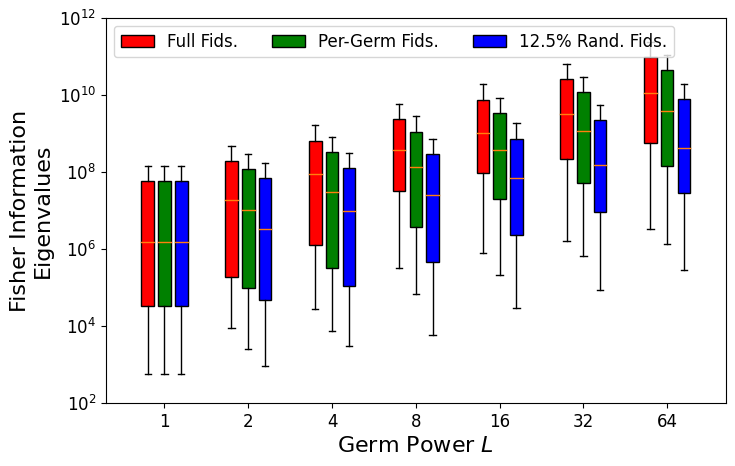

In [34]:
plot_spectra_by_L_violins([fisher_spectra_by_L_full_lite, fisher_spectra_by_L_pergermE033C30N20000_lite, fisher_spectra_by_L_pergermrand012_lite],
    lengths, num_gauge=240, labels=['Full Fids.', 'Per-Germ Fids.', '12.5% Rand. Fids.'], colors=['r','g','b'],
    filename='./figure_output/fim_grouped_boxplot.png', title='Fisher Information Eigenvalues vs L PerGermRand 3%-Lite',
    figure_size=(8,5))

In [35]:
def plot_inv_fim_eig_vs_L(fisher_spectra_by_Ls, lengths, num_gauge, labels, styles, title, ylabel, filename, figure_size=None, leg_loc=None, 
                                annotations=None):
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    fit_line = [1e-5/L for L in lengths]
    plt.plot(lengths, fit_line, 'k--', label="Heisenberg scaling")
    
    for fisher_spectra_by_L, term_styles, term_labels in zip(fisher_spectra_by_Ls, styles, labels):

        fisher_array= np.asarray(fisher_spectra_by_L)
        gmeans = np.min(fisher_array[:, num_gauge:], axis=1)
        
        plt.plot(lengths, 1/gmeans, term_styles, label=term_labels, markersize=8)

    axes = plt.gca()
    axes.set_xscale('log')
    #axes.set_xticks(eff_xs)
    #axes.set_xticklabels(lengths)
    axes.minorticks_off()
    axes.set_yscale('log')
    axes.set_ylim([1e-7, 1e-2])
    
    axes.tick_params(axis='both', which='major', labelsize=12)
    
    plt.xticks(lengths, lengths)

    plt.grid()
    #plt.legend(ncol=2, loc='lower left')
    
    #if leg_loc is None:
    #    plt.legend(loc='lower left', ncol=1, fontsize=12)
    #else:
    #    plt.legend(loc=leg_loc, ncol=1, fontsize=12)
        
    #plt.title(title, fontsize=16)
    plt.xlabel(r'Germ Power $L$', fontsize=16)
    #plt.xlim([600, 1.7e4])
    plt.ylabel(ylabel, fontsize=16)
    
    if annotations is not None:
        for annotation in annotations:
            plt.annotate(**annotation)

    plt.tight_layout()
    plt.savefig(filename, facecolor='white', dpi=300)
    plt.show()

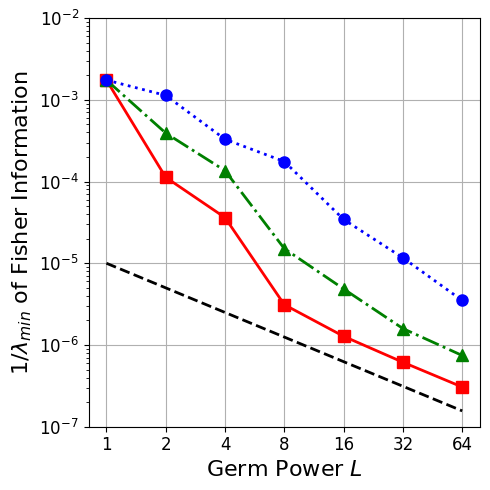

In [37]:
plot_inv_fim_eig_vs_L([fisher_spectra_by_L_full_lite, fisher_spectra_by_L_pergermE033C30N20000_lite, fisher_spectra_by_L_pergermrand012_lite],
    lengths, num_gauge=240, labels=['Full Fids.', 'Per-Germ Fids.', '12.5% Rand. Fids.'], styles=['rs-', 'g^-.', 'bo:'],
    ylabel=r'1/$\lambda_{min}$ of Fisher Information', filename='./figure_output/fig1b.png', title='Fisher Information Eigenvalues vs L PerGermRand 3%-Lite',
    figure_size=(5,5))

# Panel C

In [38]:
def plot_ddists_vs_L(ensemble_ddist_lists, labels, styles, title, ylabel, filename, figure_size=None, leg_loc=None, 
                                annotations=None):
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    fit_line = [(1/sqrt(100))/L for L in lengths]
    plt.plot(lengths, fit_line, 'k--', label="Heisenberg scaling")
    
    for ensemble_ddists, term_styles, term_labels in zip(ensemble_ddist_lists, styles, labels):

        avgs = np.mean(ensemble_ddists, axis=0)
        stds = np.std(ensemble_ddists, axis=0)
        
        plt.plot(lengths, avgs, term_styles, label=term_labels, markersize=8)

    axes = plt.gca()
    axes.set_xscale('log')
    #axes.set_xticks(eff_xs)
    #axes.set_xticklabels(lengths)
    axes.minorticks_off()
    axes.set_yscale('log')
    axes.set_ylim([1e-3, 1e0])
    
    axes.tick_params(axis='both', which='major', labelsize=12)

    plt.grid()
    #plt.legend(ncol=2, loc='lower left')
    
    plt.xticks(lengths, lengths)
    
    #if leg_loc is None:
    #    plt.legend(loc='lower left', ncol=1, fontsize=12)
    #else:
    #    plt.legend(loc=leg_loc, ncol=1, fontsize=12)
        
    #plt.title(title, fontsize=16)
    plt.xlabel(r'Germ Power $L$', fontsize=16)
    #plt.xlim([600, 1.7e4])
    plt.ylabel(ylabel, fontsize=16)
    
    if annotations is not None:
        for annotation in annotations:
            plt.annotate(**annotation)
    
    #if annotation2 is not None:
    #    plt.annotate(annotation2[0], annotation2[1], xytext= annotation2[2], arrowprops= annotation2[3], xycoords='axes fraction', textcoords='axes fraction')

    plt.tight_layout()
    plt.savefig(filename, facecolor='white', dpi=300)
    plt.show()

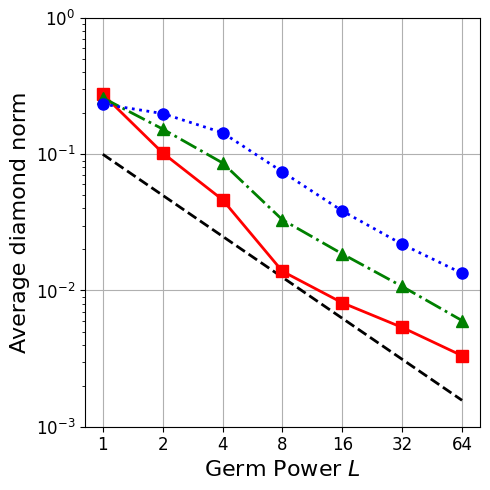

In [39]:
plot_ddists_vs_L([avg_gateset_ddists_full_lite_TP_coher, avg_gateset_ddists_pergermE033C30N20000_lite_TP_coher, avg_gateset_ddists_pergermrand012_lite_TP_coher],
               ['Full Fids.','Per-Germ Fids.', '12.5% Random Fids.'],
               ['rs-', 'g^-.', 'bo:'], 'Average Diamond Dist vs. L', 'Average diamond norm', './figure_output/fig1c.png', 
               figure_size=(5,5))

# Panel D

In [40]:
def plot_ddists_vs_num_circuits(ensemble_ddist_lists, L_dicts, labels, styles, title, ylabel, filename, figure_size=None, leg_loc=None, 
                                annotations=None):
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
        
    plt.plot([0,0],[0,0], 'k--', label='Heisenberg scaling\n(trend line)')
    
    for ensemble_ddists, L_dict, term_styles, term_labels in zip(ensemble_ddist_lists, L_dicts, styles, labels):
        lengths = list(L_dict.keys())
        eff_xs = list(L_dict.values())

        avgs = np.mean(ensemble_ddists, axis=0)
        stds = np.std(ensemble_ddists, axis=0)
        
        plt.plot(eff_xs, avgs, term_styles, label=term_labels, markersize=8)

    axes = plt.gca()
    axes.set_xscale('log')
    #axes.set_xticks(eff_xs)
    #axes.set_xticklabels(lengths)
    #axes.minorticks_off()
    axes.set_yscale('log')
    axes.set_ylim([1e-3, 1])
    
    axes.tick_params(axis='both', which='major', labelsize=12)

    plt.grid()
    #plt.legend(ncol=2, loc='lower left')
    
    plt.legend(loc='upper left', ncol=1, fontsize=16, bbox_to_anchor=(1.05, 0.8), borderaxespad=0., frameon=False)
        
    #plt.title(title, fontsize=16)
    plt.xlabel('Number of Circuits', fontsize=16)
    plt.xlim([500, 1.7e4])
    plt.ylabel(ylabel, fontsize=16)
    
    if annotations is not None:
        for annotation in annotations:
            plt.annotate(**annotation)
    
    #if annotation2 is not None:
    #    plt.annotate(annotation2[0], annotation2[1], xytext= annotation2[2], arrowprops= annotation2[3], xycoords='axes fraction', textcoords='axes fraction')

    plt.tight_layout()
    
    plt.savefig(filename, facecolor='white', dpi=300)
    plt.show()

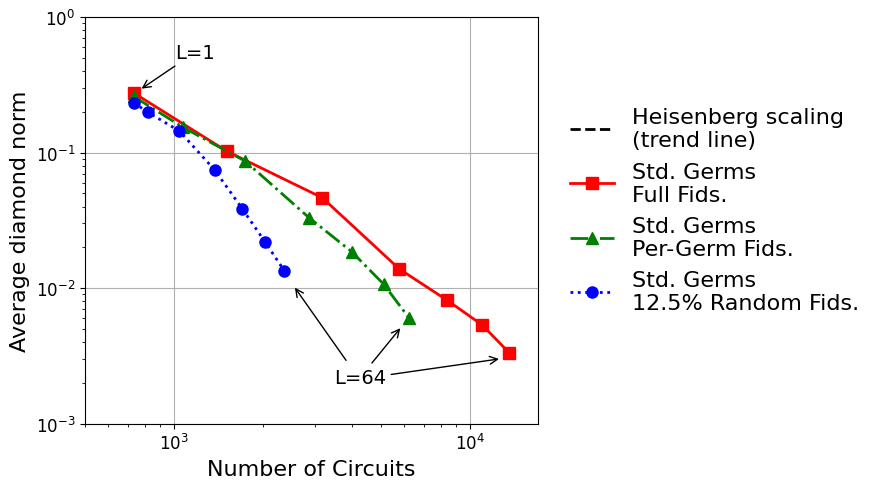

In [41]:
fl_shots = get_shot_counts_by_L(comb_edesign['Full','Lite'], num_shots=1)
pg_shots = get_shot_counts_by_L(comb_edesign['PerGermE0.033C30.00N20000', 'Lite'], num_shots=1)
pgr012_shots= get_shot_counts_by_L(comb_edesign['PerGermRand0.12-0', 'Lite'], num_shots=1)

plot_ddists_vs_num_circuits([avg_gateset_ddists_full_lite_TP_coher, avg_gateset_ddists_pergermE033C30N20000_lite_TP_coher, avg_gateset_ddists_pergermrand012_lite_TP_coher],
               [fl_shots, pg_shots, pgr012_shots],
               ['Std. Germs\nFull Fids.','Std. Germs\nPer-Germ Fids.', 'Std. Germs\n12.5% Random Fids.'],
               ['rs-', 'g^-.', 'bo:'], 'Average Diamond Dist vs. Num Ckts', 'Average diamond norm', './figure_output/fig1d.png', 
               figure_size=(9,5),
               annotations=[
                   {'text': "L=1", 'xy': (0.12, 0.82), 'xytext':(0.2, 0.9),
                    'arrowprops': {'arrowstyle': "->",'connectionstyle':"arc3"},
                    'textcoords': 'axes fraction', 'xycoords': 'axes fraction', 'fontsize': 14},
                   {'text': "L=64", 'xy': (0.7, 0.24), 'xytext':(0.55, 0.1),
                    'arrowprops': {'arrowstyle': "->",'connectionstyle':"arc3"},
                    'textcoords': 'axes fraction', 'xycoords': 'axes fraction', 'fontsize': 14},
                   {'text': "", 'xy': (0.46, 0.34), 'xytext':(0.58, 0.15),
                    'arrowprops': {'arrowstyle': "->",'connectionstyle':"arc3"},
                    'textcoords': 'axes fraction', 'xycoords': 'axes fraction', 'fontsize': 14},
                   {'text': "", 'xy': (0.92, 0.16), 'xytext':(0.67, 0.12),
                    'arrowprops': {'arrowstyle': "->",'connectionstyle':"arc3"},
                    'textcoords': 'axes fraction', 'xycoords': 'axes fraction', 'fontsize': 14}
               ])

# Related analysis could be resource estimation, i.e., time to execute edesign on x-axis instead of number of circuits only
# (to take into account longer circuits at high L)

# Maybe even put LGST on this figure as a reference

## Table 1

In [42]:
import pygsti
from pygsti.tools.edesigntools import calculate_edesign_estimated_runtime

In [43]:
params_dict = {}

# Transmons params (units in seconds)
params_dict['Transmon'] = dict(
    gate_time_1Q=20e-9,
    gate_time_2Q=200e-9,
    total_shots_per_circuit=100,
    measure_reset_time=1e-6,
    interbatch_latency=0.1,
    shots_per_circuit_per_batch=10,
    circuits_per_batch=200)

# Trapped ion params (units in seconds, 1e-6 is micro)
params_dict['Trapped Ion'] = dict(
    gate_time_1Q=10e-6,
    gate_time_2Q=100e-6,
    total_shots_per_circuit=100, # 100 is low but reasonable times across the board
    measure_reset_time=1e-3,
    interbatch_latency=0.1,
    shots_per_circuit_per_batch=100,
    circuits_per_batch=200)

# Si params (units in seconds)
params_dict['Si'] = dict(
    gate_time_1Q=20e-9,
    gate_time_2Q=200e-9,
    total_shots_per_circuit=100,
    measure_reset_time=1e-4,
    interbatch_latency=0.1,
    shots_per_circuit_per_batch=100,
    circuits_per_batch=200)

In [44]:
for ed in [('Full', 'Full'), ('Full', 'Lite'), ('PerGermE0.033C30.00N20000', 'Lite'), ('PerGermRand0.12-0','Lite')]:
    for device, params in params_dict.items():
        print(f'Runtime for device {device} for design {ed}: {calculate_edesign_estimated_runtime(edesign_dict[ed], **params)}')
    print()

Runtime for device Transmon for design ('Full', 'Full'): 294.1814080000013
Runtime for device Trapped Ion for design ('Full', 'Full'): 8931.604000001687
Runtime for device Si for design ('Full', 'Full'): 597.2960079999632

Runtime for device Transmon for design ('Full', 'Lite'): 71.81858999999999
Runtime for device Trapped Ion for design ('Full', 'Lite'): 2096.49499999993
Runtime for device Si for design ('Full', 'Lite'): 144.41798999999637

Runtime for device Transmon for design ('PerGermE0.033C30.00N20000', 'Lite'): 33.31022399999998
Runtime for device Trapped Ion for design ('PerGermE0.033C30.00N20000', 'Lite'): 969.9620000000134
Runtime for device Si for design ('PerGermE0.033C30.00N20000', 'Lite'): 66.21692400000003

Runtime for device Transmon for design ('PerGermRand0.12-0', 'Lite'): 12.428064000000006
Runtime for device Trapped Ion for design ('PerGermRand0.12-0', 'Lite'): 333.3819999999987
Runtime for device Si for design ('PerGermRand0.12-0', 'Lite'): 25.021763999999923

